In [74]:
# In this Python script we attempt to solve a partial differential equation (PDE).
# We will use the 'FiPy' module to do this.  I found that the module was quite
# difficult to learn.  A lot of the code below is based on code shown in the
# FiPy documentation.  I made a few tweaks here and there.

In [75]:
# Note that FiPy is note one of the standard modules and you will likely
# have to install it manually in order to use it.  In a Jupyter notebook, I
# found that the following install command worked.
!pip install fipy

In [76]:
# We can now import the FiPy module as well as other standard modules.
from fipy import *
import matplotlib.pyplot as plt
import numpy as np

In [77]:
# We will attempt to solve the 1-D heat equation, also  known as the 1-D 
# diffusion equation:
# alpha*T" = dT/dt
# Here, T is temperature, alpha is thermal diffusivity (a diffusion coefficient),
# and t is time.  T" represents two spatial derivative of temperature.

# We will solve for temperature profiles along a 1-D rod subject to particular
# boundary conditions and some initial temperature profile.  We will get solutions
# at a bunch of different times between t = 0 (our initial condition) and a final
# time.  We need to set up a spatial grid that defines the length of our rod and
# the number of points between the two ends for which we will calculate the
# temperature.  We will have a rod that is 1.5 m long and we will extract the 
# temperature at 50 equally-spaced points.
nx = 50
dx = 1.5/nx
mesh = Grid1D(nx = nx, dx = dx)

In [78]:
# Let's set up a list of x-coordinates to be used later for plotting purposes.
xx = np.arange(0, nx*dx, dx)
xx

array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ,
       0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.51, 0.54, 0.57, 0.6 , 0.63,
       0.66, 0.69, 0.72, 0.75, 0.78, 0.81, 0.84, 0.87, 0.9 , 0.93, 0.96,
       0.99, 1.02, 1.05, 1.08, 1.11, 1.14, 1.17, 1.2 , 1.23, 1.26, 1.29,
       1.32, 1.35, 1.38, 1.41, 1.44, 1.47])

In [79]:
# Define the initial temperature profile of the bar.  We will assume that the
# bar is initially at a uniform temperature of 20 celsius.
temperature = CellVariable(name = '', mesh = mesh, value = 20.)

In [80]:
# The thermal diffusivity of copper near room temperature is about
# 0.0001 m^2/s
alpha = 1e-4 
print('The thermal diffusivity of copper near romm temperature is', alpha, 'm^2/s.')

The thermal diffusivity of copper near romm temperature is 0.0001 m^2/s.


In [81]:
# These are the boundary conditions, i.e. the temperatures in celsius of the 
# two ends of the bar for t > 0.
leftEnd = 100
rightEnd = 20

In [82]:
# Here's the syntax that FiPy uses to define the boundary conditions.
temperature.constrain(rightEnd, mesh.facesRight)
temperature.constrain(leftEnd, mesh.facesLeft)

In [83]:
# Here's how we define the partial differential equation (PDE) that we hope to
# solve.  'TransientTerm()' represents the dT/dt and 'ExplicitDiffusionTerm()'
# represents the T" with a coefficient of alpha.
eqX = TransientTerm() == ExplicitDiffusionTerm(coeff = alpha)

In [84]:
# The 'timeStepDuration' that has been selected was just copied from the 
# example in the FiPy documentation.  It represents the amount of time
# between successive solutions for the temperature profile.  We can run the 
# solver for as many steps as we want.  I selected 2500 steps which gives
# the bar enough time to reach the expected equilibrium temperature profile. 
timeStepDuration = 0.9*dx**2/(2*alpha)
print('The time between steps is', timeStepDuration, 'seconds.')
steps = int(2.5e3)
print('The total elapsed time is', steps*timeStepDuration/3600, 'hours.')

The time between steps is 4.05 seconds.
The total elapsed time is 2.8125 hours.


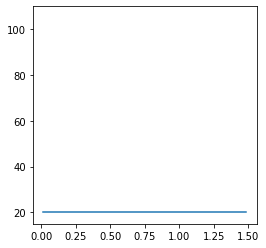

In [85]:
# A line a code that I had to look up online.  The 'viewer' that has been defined
# will allow use to look that the intermediate solutions for the temperature
# profiles as the loop below advances the solutions from the intial time all the
# way through to step 2500.
viewer = MatplotlibViewer(vars=(temperature,), datamin=15, datamax=110, legend=None)

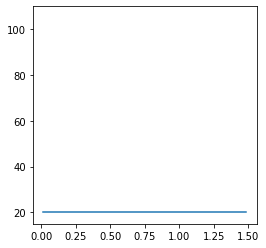

<Figure size 432x288 with 0 Axes>

In [86]:
# Here's how we call the 'viewer'.  This plot will show use the temperature
# profile at t = 0.  It will just be a uniform temperatire of 20 C.
print('A plot of the initial temperature profile of the copper bar.')
viewer.plot();

In [87]:
# I couldn't figure out how to extract the actual temperature data from the FiPy
# solver at the individual solution times.  After a lot of time on Google, I came
# up with a work around.  The 'TSVViewer' function will allow us to write the 
# desired data to a file.  I will then read that file back into Python so that
# it can be stored in an array.  I assume that there must be a better way...
from fipy.viewers.tsvViewer import TSVViewer  

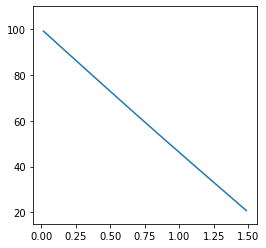

The solution at the final time of 2.8113749999999995 hours.


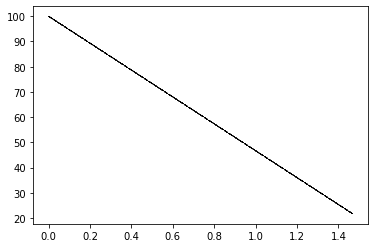

In [88]:
# Here's the for loop that will step through the different times and then call
# the PDE solver at each iteration.  'solnData[]' will be a list of the temperature
# profiles to be used for plotting later.
solnData = []
for step in range(steps):
     # Here's where we call the PDE solver.
     eqX.solve(var = temperature, dt = timeStepDuration)
     # I don't want to see the temperature profiles at all 2500 of the solution
     # times.  This if statement selects 20 solutions, uniformly spaced in time
     # to look at.
     if step % int(steps/20) == 0:
         # The expected equilibrium solution is a linear temperature profile
         # starting from 100 C at the left end and ending at 20 C at the right
         # end.  We will add this line to out plots so that we can see how our
         # solutions approach equilibium as time evolves.
         plt.plot(xx, leftEnd - (leftEnd - rightEnd)/(nx*dx)*xx, 'k--', linewidth = 0.5)
         # Next, we call 'viewer' to display the relevant temperature profile.
         viewer.plot()
         print('The time is', step*timeStepDuration/3600, 'hours.')
         # Then, TSVViewer is used the write the data to a file.  This file will
         # be overwritten each time the if condition is true.  If you wanted to
         # keep the data, you could modify the code so that the file name is
         # changed each time 'TSVViewer' is called.
         TSVViewer(vars=(temperature)).plot('data1.txt')
         # This next block of code opens the file that was just created and then
         # reads it into memory line by line.  We then load the data into 'data'
         # using 'np.loadtex()' while skipping the first line.  The first line
         # needs to be skipped because TSVViewer adds a one-line header to the file.
         # When the indentation after the 'with' statement ends, the file is closed.
         with open('data1.txt') as f:
             lines = (line for line in f if not line.startswith('#'))
             data = np.loadtxt(lines, skiprows = 1)[:, 1]
         # Add the data that we just extracted in a convoluted way to a list
         # of solutions.
         solnData = solnData + [data]
     elif step == steps - 1:
         # Do all of those same steps if we've reached that last step in the loop.
         plt.plot(xx, leftEnd - (leftEnd - rightEnd)/(nx*dx)*xx, 'k--', linewidth = 0.5)
         viewer.plot()
         print('The solution at the final time of', step*timeStepDuration/3600, 'hours.')
         with open('data1.txt') as f:
             lines = (line for line in f if not line.startswith('#'))
             data = np.loadtxt(lines, skiprows = 1)[:, 1]
         solnData = solnData + [data]

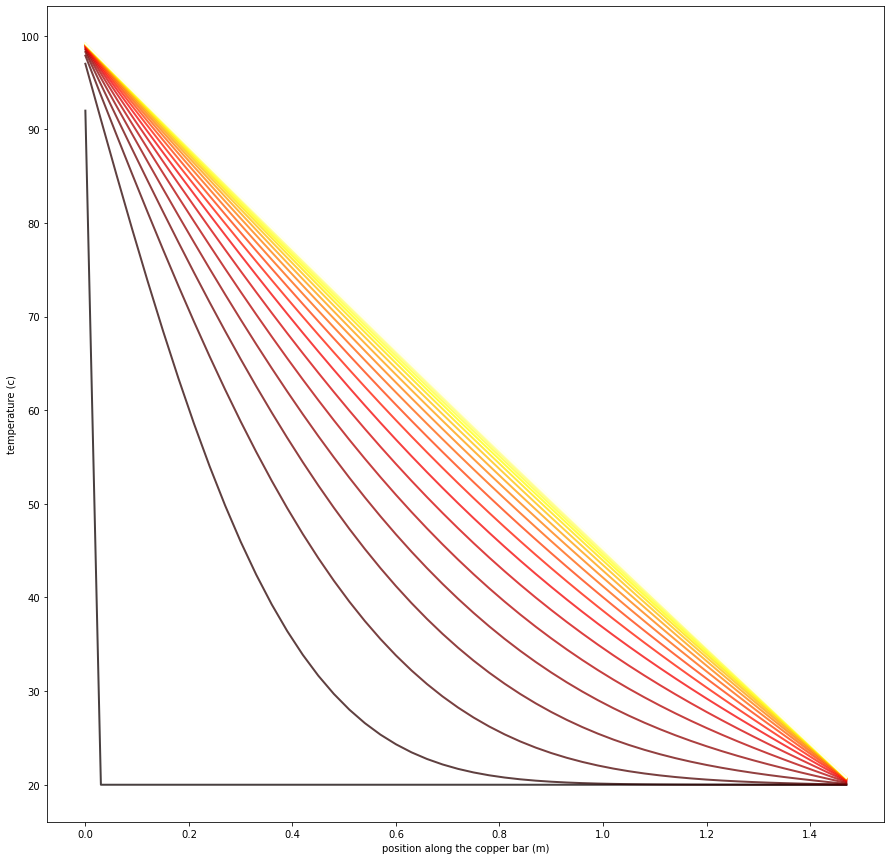

In [89]:
# Finally, we can now plot all of the temperature profiles at the different
# times on a single graph.             
plt.figure(figsize=(15,15))

# We'll use a colormap (cm) to nicely color the successive curves.
from matplotlib.pyplot import cm
color = cm.hot(np.linspace(0,1,len(solnData)))
for i in range(len(solnData)):
    plt.plot(xx, solnData[i], c = color[i], linewidth = 2, alpha = 0.75)   
plt.xlabel('position along the copper bar (m)')
plt.ylabel('temperature (c)');

In [90]:
# We didn't have to start with a rod at a uniform temperature at t = 0.
# We can start with whatever initial temperature profile we want.  
# Here's a linear/sinusoidal initial temperature profile.
temperature = CellVariable(name='', mesh=mesh, value=(40*xx - 50*np.sin(2*np.pi*xx/(nx*dx))))

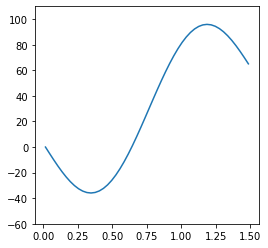

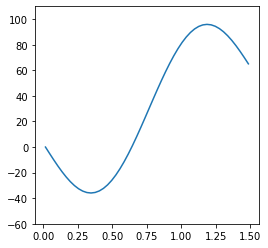

In [91]:
# Besides, this change, we'll run all of the same code from above again, this
# time without all of the comments.
viewer = MatplotlibViewer(vars=(temperature,), datamin=-60, datamax=110, legend=None)
print('A plot of the initial temperature profile of the copper bar.')
viewer.plot()

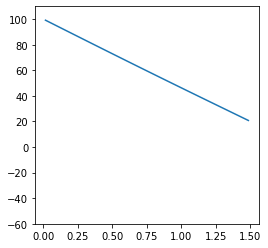

The solution at the final time of 2.8113749999999995 hours.


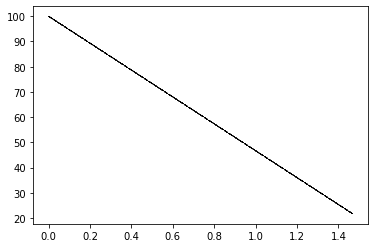

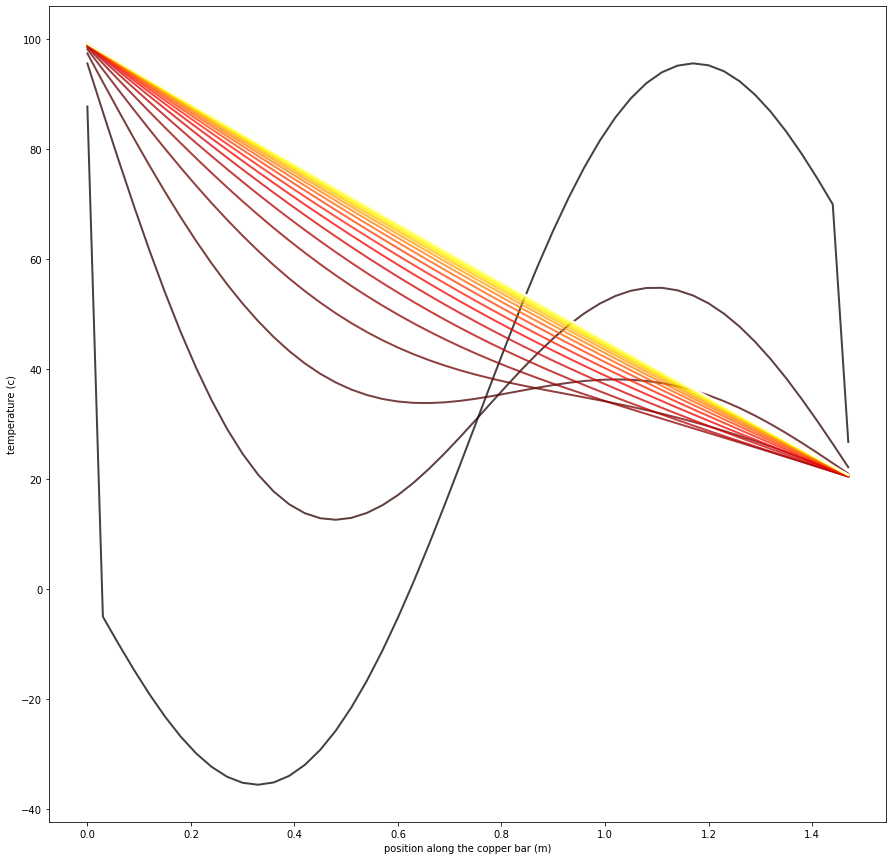

In [92]:
solnData = []
for step in range(steps):
     eqX.solve(var = temperature, dt = timeStepDuration)
     if step % int(steps/20) == 0:
         plt.plot(xx, leftEnd - (leftEnd - rightEnd)/(nx*dx)*xx, 'k--', linewidth = 0.5)
         viewer.plot()
         print('The time is', step*timeStepDuration/3600, 'hours.')
         TSVViewer(vars=(temperature)).plot('data1.txt')
         with open('data1.txt') as f:
             lines = (line for line in f if not line.startswith('#'))
             data = np.loadtxt(lines, skiprows = 1)[:, 1]
         solnData = solnData + [data]
     elif step == steps - 1:
         plt.plot(xx, leftEnd - (leftEnd - rightEnd)/(nx*dx)*xx, 'k--', linewidth = 0.5)
         viewer.plot()
         print('The solution at the final time of', step*timeStepDuration/3600, 'hours.')
         with open('data1.txt') as f:
             lines = (line for line in f if not line.startswith('#'))
             data = np.loadtxt(lines, skiprows = 1)[:, 1]
         solnData = solnData + [data]
plt.figure(figsize=(15,15))
color = cm.hot(np.linspace(0,1,len(solnData)))
for i in range(len(solnData)):
    plt.plot(xx, solnData[i], c = color[i], linewidth = 2, alpha = 0.75)   
plt.xlabel('position along the copper bar (m)')
plt.ylabel('temperature (c)');